# Transfer learning of BERT/mBERT for binary classification

BERT embedding + Linear Layer & SoftMax

In [1]:
import os
import logging
import re
from pprint import pprint
from glob import glob

import pandas as pd
import numpy as np

import wandb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from scipy.special import softmax
from matplotlib import pyplot as plt
import seaborn as sns

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [2]:
# (optional) Login to WANDB to monitor training progress
try:
    wandb.login()
except Exception as e:
    pprint(e)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matjazmav (use `wandb login --relogin` to force relogin)


In [3]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Prepare datasets

In [4]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower()
    return text

def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df.columns = ["text", "labels"]
    data_df["text"] = data_df["text"].map(clean_text)

    return data_df

def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["text"] = data_df["content"].map(clean_text)
    data_df["labels"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")

    data_df = data_df.drop(columns=set(data_df.columns) - {"text", "labels"})

    return data_df

train_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/english_dataset.tsv")

test_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv")
test_de_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv")
test_hi_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv")
_, test_si_df = train_test_split(load_senti_news_dataset("/hdd/matjazibb/dataset/senti-news/SentiNews_sentence-level.txt"), test_size=0.005)

In [5]:
def plot_class_hist(data_df, title):
    data_df["labels"].value_counts().plot(kind="bar", title=f"Class distirbution: {title}")

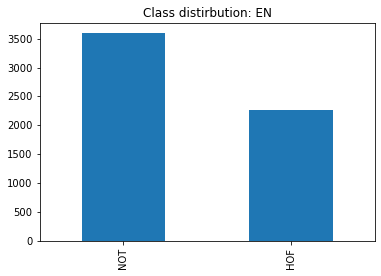

In [6]:
plot_class_hist(train_en_df, "EN")

Since classes are unablanced we will use class weights when training the models

## Train BERT models

In [11]:
def get_bert_model(model_name, hf_model_type, hf_model_name, class_weights=None):
    model_args = ClassificationArgs()
    model_args.output_dir=f"/hdd/matjazibb/outputs/{model_name}"
    model_args.best_model_dir=f"{model_args.output_dir}/best_model"
    model_args.cache_dir=f"/hdd/matjazibb/cache_dir/{model_name}"
    model_args.tensorboard_dir=f"/hdd/matjazibb/runs/{model_name}"

    # Training HP
    model_args.fp16 = False
    model_args.num_train_epochs = 1
    model_args.learning_rate = 1e-5
    model_args.polynomial_decay_schedule_lr_end = 1e-7
    model_args.train_batch_size = 1 # 12GB GPU memory is not enough
    model_args.weight_decay = 1e-7
    model_args.scheduler = "polynomial_decay_schedule_with_warmup"

    # Dataset
    model_args.labels_list = ["HOF", "NOT"]

    # Evaluation
    model_args.evaluate_during_training = False
    model_args.evaluate_each_epoch = False

    # Outputs & cache
    model_args.save_model_every_epoch = True
    model_args.save_steps = -1
    model_args.overwrite_output_dir = True
    model_args.wandb_project = "eval-bert"

    need_training = not os.path.exists(model_args.output_dir)
    pretrained_model_name = hf_model_name if need_training else model_args.output_dir

    return need_training, ClassificationModel(
        hf_model_type, pretrained_model_name,
        args=model_args,
        use_cuda=True,
        cuda_device=0,
        num_labels=2,
        weight=class_weights
    )

In [8]:
def get_class_weights(df):
    return compute_class_weight('balanced', ["HOF", "NOT"], train_en_df["labels"]).tolist()

In [13]:
need_training, bert_en_model = get_bert_model(
    "bert_en",
    "bert",
    "bert-base-uncased",
    class_weights = get_class_weights(train_en_df)
)

if need_training:
    bert_en_model.train_model(train_en_df)

In [14]:
need_training, mbert_en_model = get_bert_model(
    "mbert_en",
    "bert",
    "bert-base-multilingual-uncased",
    class_weights = get_class_weights(train_en_df)
)

if need_training:
    mbert_en_model.train_model(train_en_df)

## Evaluate BERT models

In [15]:
def eval_model(model, data_df):
    y_hat, p_hat = model.predict(data_df["text"].tolist())
    p_hat = softmax(p_hat, axis=1)[:,0]

    f1 = sklearn.metrics.f1_score(data_df["labels"], y_hat, pos_label="HOF")
    fpr, tpr, t = sklearn.metrics.roc_curve(data_df["labels"], p_hat, pos_label="HOF")
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, roc_auc, fpr, tpr

In [16]:
eval_models = [
    ("BERT-HASOC-en", bert_en_model, test_en_df),
    ("BERT-HASOC-de", bert_en_model, test_de_df),
    ("BERT-HASOC-hi", bert_en_model, test_hi_df),
    ("BERT-SentiNews-si", bert_en_model, test_si_df),

    ("mBERT-HASOC-en", mbert_en_model, test_en_df),
    ("mBERT-HASOC-de", mbert_en_model, test_de_df),
    ("mBERT-HASOC-hi", mbert_en_model, test_hi_df),
    ("mBERT-SentiNews-si", mbert_en_model, test_si_df),
]

results = []

for model_name, model, data_df in eval_models:
    f1, roc_auc, fpr, tpr = eval_model(model, data_df)
    results += [(model_name, f1, roc_auc, fpr, tpr)]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

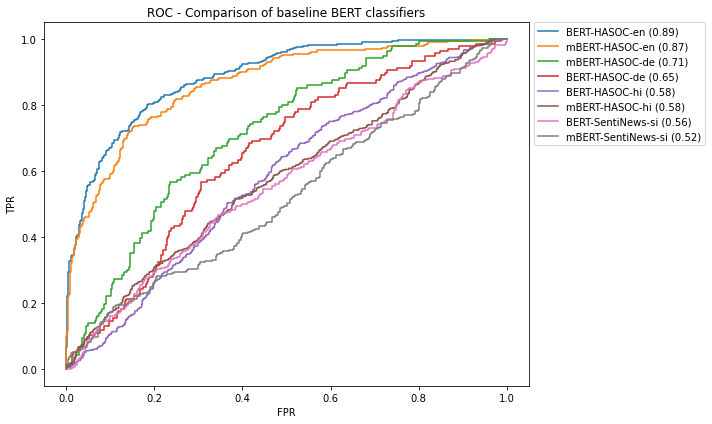

In [17]:
plt.figure(figsize=(10,6))
for model_name, f1, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[2], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline BERT classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.savefig("results/eval-bert-rocs.pdf")

In [18]:
results_df = pd.DataFrame(results, columns=["model_name", "f1", "roc_auc", "fpr", "tpr"])
results_df = results_df.drop(columns=["fpr", "tpr"])
results_df.to_csv("results/eval-bert.csv", index=False)
results_df.head(30)

,model_name,f1,roc_auc
0,BERT-HASOC-en,0.644243,0.888034
1,BERT-HASOC-de,0.242623,0.652074
2,BERT-HASOC-hi,0.013051,0.582100
3,BERT-SentiNews-si,0.076923,0.559343
4,mBERT-HASOC-en,0.623037,0.865017
5,mBERT-HASOC-de,0.392157,0.714821
6,mBERT-HASOC-hi,0.375139,0.576893
7,mBERT-SentiNews-si,0.052478,0.521419


In [ ]:
%reset